In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
from src import utils, lda_utils, nlp_topic_utils
from bs4 import BeautifulSoup
import itertools

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import string

from datetime import datetime
from wordcloud import WordCloud

from collections import Counter

In [2]:
# nltk.download('wordnet')

contracted_words_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

# Wall Street Forum

## EDA - Raw Data

In [3]:
wallstreet = pd.read_csv('data/wallstreet.csv')

In [4]:
wallstreet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45372 entries, 0 to 45371
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   postID                45372 non-null  int64 
 1   threadID              45372 non-null  int64 
 2   threadTitle           45370 non-null  object
 3   URL                   45372 non-null  object
 4   subforum              45372 non-null  object
 5   authorName            45372 non-null  object
 6   postAuthorMembership  45372 non-null  object
 7   postAuthorJoinDate    45372 non-null  object
 8   authorReputation      45372 non-null  int64 
 9   postDate              45372 non-null  object
 10  postSequence          45372 non-null  int64 
 11  likes                 45372 non-null  int64 
 12  flatContent           45372 non-null  object
 13  contentWithHTMLTag    45372 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.8+ MB


In [5]:
wallstreet.head()

,postID,threadID,threadTitle,URL,subforum,authorName,postAuthorMembership,postAuthorJoinDate,authorReputation,postDate,postSequence,likes,flatContent,contentWithHTMLTag
0,6,5,Hi,http://x7bwsmcore5fmx56.onion/viewtopic.php?id=5,Introductions,Punka421,New member,2016-10-26,-3,2016-10-26 13:58:36,1,0,\nJust thought I'd introduce myself. I am new ...,"<div class=""entry-content"">\n<p>Just thought I..."
1,7,5,Hi,http://x7bwsmcore5fmx56.onion/viewtopic.php?id=5,Introductions,WSM,Administrator,2016-10-02,66,2016-10-26 14:04:04,2,0,\nHello Nice to see you here!Regards\n,"<div class=""entry-content"">\n<p>Hello <img alt..."
2,8,6,WSM Updates - Changelog (Page 1 of 4),http://x7bwsmcore5fmx56.onion/viewtopic.php?id=6,Announcements,WSM,Administrator,2016-10-02,74,2016-10-26 16:54:27,1,0,\nHello everyone.I would like to tell you that...,"<div class=""entry-content"">\n<p>Hello everyone..."
3,11,5,Hi,http://x7bwsmcore5fmx56.onion/viewtopic.php?id=5,Introductions,Estrazy,Banned,2016-10-27,0,2016-10-27 14:00:16,3,0,\nHello Punka! nice to meet you!As you asked h...,"<div class=""entry-content"">\n<p>Hello Punka! n..."
4,13,6,WSM Updates - Changelog (Page 1 of 4),http://x7bwsmcore5fmx56.onion/viewtopic.php?id=6,Announcements,WSM,Administrator,2016-10-02,74,2016-11-02 15:42:27,2,0,"\nChangelog from Wednesday, 2nd November 2016F...","<div class=""entry-content"">\n<h5>Changelog fro..."


In [6]:
total_num_posts_wall = wallstreet.shape[0] 
print('# of Postings: ', total_num_posts_wall)
print('# of Unique Threads : ', len(wallstreet['threadID'].unique()))
print('# of Unique Subforums : ', len(wallstreet['subforum'].unique()))
print('# of Unique Authors : ', len(wallstreet['authorName'].unique()))
print('# of Membership Types : ', len(wallstreet['postAuthorMembership'].unique()))

# of Postings:  45372
# of Unique Threads :  8755
# of Unique Subforums :  40
# of Unique Authors :  5533
# of Membership Types :  8


In [7]:
wall_authors = pd.DataFrame(wallstreet['authorName'].value_counts()).reset_index()
wall_authors.columns = ['author','num_postings']
wall_authors['prcnt_total_posts'] = wall_authors['num_postings'] / total_num_posts_wall
wall_authors.head(10)

,author,num_postings,prcnt_total_posts
0,med3l1n,4889,0.107754
1,6LACK,1500,0.033060
2,leaguemode,1146,0.025258
3,ExpectUS,1113,0.024531
4,PurityRing,1111,0.024486
5,BonesKoopa,476,0.010491
6,Icepapi,446,0.009830
7,code48k,379,0.008353
8,deusxmacina,354,0.007802
9,dabbingtimes,334,0.007361


In [8]:
wall_threads = pd.DataFrame(wallstreet['threadTitle'].value_counts()).reset_index()
wall_threads.columns = ['thread_topic','num_postings']
wall_threads['prcnt_total_posts'] = wall_threads['num_postings'] / total_num_posts_wall
wall_threads.head(10)

,thread_topic,num_postings,prcnt_total_posts
0,GozNym 2.0 Banking Bot (Page 1 of 3),75,0.001653
1,GozNym 2.0 Banking Bot (Page 2 of 3),75,0.001653
2,[Price & Version update] BTC ATM Malware,73,0.001609
3,GozNym 2.0 Banking Bot (Page 3 of 3),56,0.001234
4,Hello,52,0.001146
5,US Tax Refund: 2018 Tax W2 Forms With AGI & DO...,50,0.001102
6,CASHAPP GUIDE,50,0.001102
7,ANZ AU Bank accounts with security Q&A! (Page ...,50,0.001102
8,ANZ AU Bank accounts with security Q&A! (Page ...,50,0.001102
9,US Tax Refund: 2018 Tax W2 Forms With AGI & DO...,50,0.001102


In [9]:
wall_subforums = pd.DataFrame(wallstreet['subforum'].value_counts()).reset_index()
wall_subforums.columns = ['subforum','num_postings']
wall_subforums['prcnt_total_posts'] = wall_subforums['num_postings'] / total_num_posts_wall
wall_subforums.head(15)

,subforum,num_postings,prcnt_total_posts
0,Fraud,12277,0.270585
1,General Questions,5225,0.115159
2,Carding Stuff,3836,0.084546
3,Services,2973,0.065525
4,Cannabis,2431,0.053579
5,Introductions,2418,0.053293
6,Counterfeits,1727,0.038063
7,Stimulants,1537,0.033876
8,Announcements,1507,0.033214
9,Digital goods,1443,0.031804


In [10]:
wall_joindate = pd.DataFrame(wallstreet['postAuthorJoinDate'].value_counts()).reset_index()
wall_joindate.columns = ['join_date','count']
wall_joindate['prcnt_total_posts'] = wall_joindate['count'] / total_num_posts_wall
wall_joindate.head(10)

,join_date,count,prcnt_total_posts
0,Despacitoland,4889,0.107754
1,G,1500,0.033060
2,2017-11-06,1227,0.027043
3,2018-01-10,1146,0.025258
4,InterWebz,1113,0.024531
5,2017-07-27,524,0.011549
6,2018-03-03,498,0.010976
7,2017-11-09,427,0.009411
8,2018-05-06,415,0.009147
9,2017-10-17,403,0.008882


C:\Users\morga\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


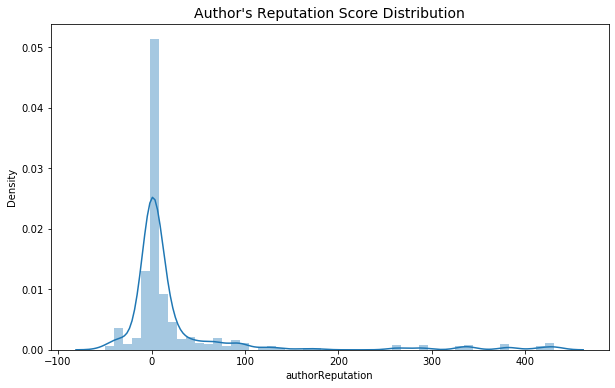

In [11]:
# Max value ~ 5,400.
constraint = 500
reputation = wallstreet[wallstreet['authorReputation'] < constraint]['authorReputation']
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(reputation)
ax.set_title("Author's Reputation Score Distribution", fontsize=14);

C:\Users\morga\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\morga\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


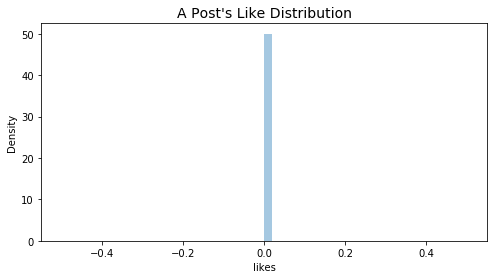

In [12]:
constraint = 100
likes = wallstreet[wallstreet['likes'] < constraint]['likes']
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.distplot(likes)
ax.set_title("A Post's Like Distribution", fontsize=14);

---
## Data Processing / Feature Engineering

In [13]:
# wsm = Wall Street Market
addtl_stop_words = ['still', 'got', 'guy', 'say', 'still', 'thing', 'us', 'will', 'get', 'ok', 'we', 'please', 'would', 'could', 'im']

stop_words = stopwords.words("english")#.append(append_to_stopwords)
stop_words = stop_words + addtl_stop_words
stop_words_dict = Counter(stop_words)

# List of punctuation
addtl_punc = ['...']
punc = list(set(string.punctuation))
punc = punc + addtl_punc

In [20]:
wallstreet_v2 = wallstreet.copy()

wallstreet_v2['post_date_dt'] = wallstreet_v2['postDate'].apply(utils.fix_postdate_col)
wallstreet_v2['author_join_date'] = wallstreet_v2.apply(lambda x: utils.fix_author_join_date_col(x['postAuthorJoinDate'], x['postAuthorMembership'], x['post_date_dt']), axis=1)
wallstreet_v2['num_days_member_when_posted'] = wallstreet_v2['post_date_dt'].dt.date - wallstreet_v2['author_join_date'].dt.date
wallstreet_v2['num_days_member_when_posted'] = wallstreet_v2['num_days_member_when_posted'].dt.days

cols_to_drop = ['URL', 'likes', 'postDate', 'postAuthorJoinDate', 'flatContent']
wallstreet_v2.drop(cols_to_drop, axis=1, inplace=True)

wallstreet_v2['processed_text'] = wallstreet_v2['contentWithHTMLTag'].apply(lambda x: nlp_topic_utils.process_text(x, contracted_words_dict, punc, stop_words_dict))

In [24]:
wallstreet_v3.to_csv('data/wallstreet_master.csv', index=False)

---
# EDA using Engineering Features

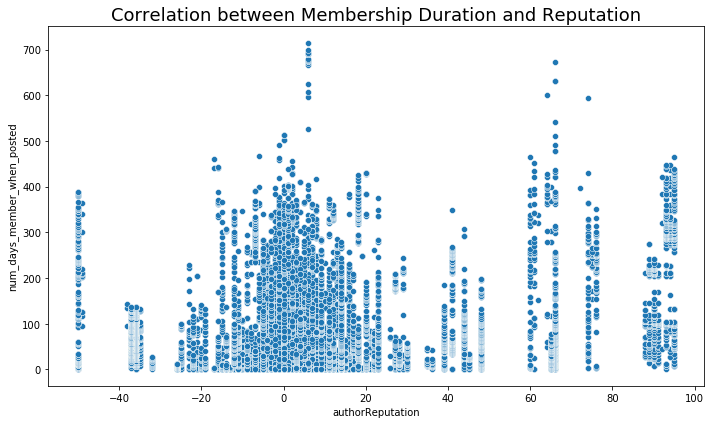

In [25]:
rep_limit = 500
excl_rep_outliers = wallstreet_v2[wallstreet_v2['authorReputation'] < rep_limit]

plt.figure(figsize=(10,6))

sns.scatterplot(y='num_days_member_when_posted', x='authorReputation', data=excl_rep_outliers)
plt.title('Correlation between Membership Duration and Reputation', fontsize=18)
plt.tight_layout();

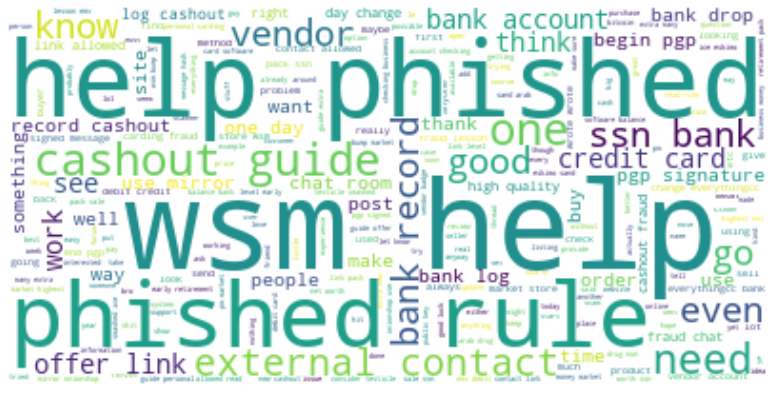

In [28]:
max_words=100000
rel_scaling = 0

wallstreet_v2['wordcloud_text'] = wallstreet_v2['processed_text'].apply(lambda x: ' '.join(x))
joined_wordcloud_text = ' '.join(wallstreet_v3['wordcloud_text'])

wordcloud = WordCloud(background_color='white', max_words=max_words, contour_color='steelblue')
wordcloud.generate(joined_wordcloud_text)

plt.figure(figsize=(20,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

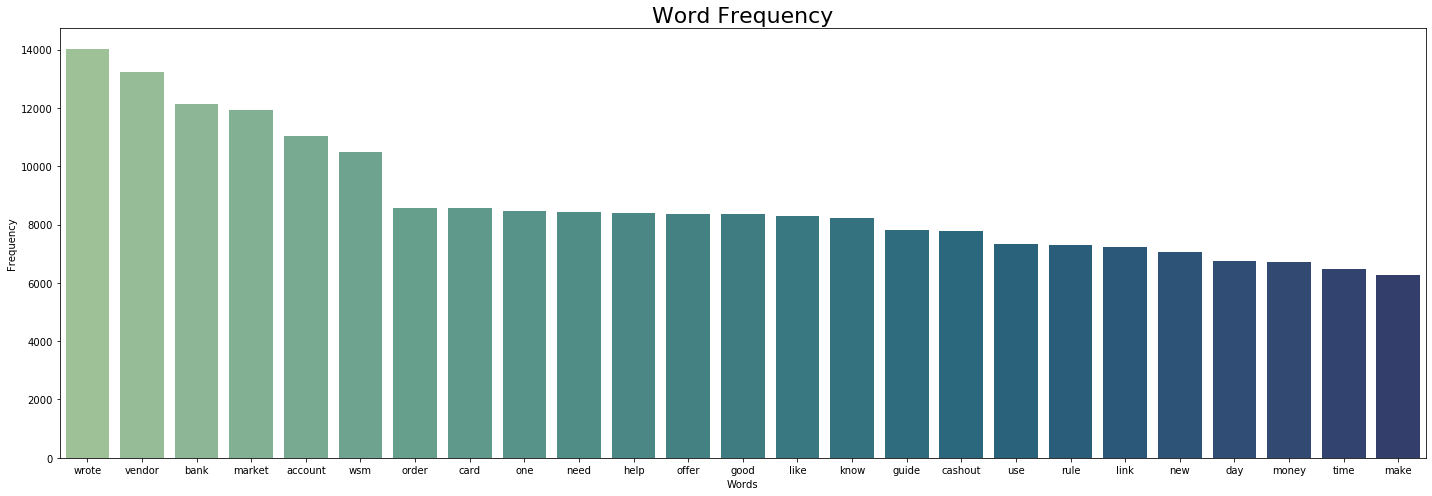

In [30]:
all_words_arr = joined_wordcloud_text.split(' ')
word_freq_df = pd.DataFrame(pd.Series(all_words_arr).value_counts()).reset_index()
word_freq_df.columns = ['word', 'freq'] 

top25_words = word_freq_df[:25]
fig, ax = plt.subplots(figsize=(20,7))

ax = sns.barplot(x='word', y='freq', data=top25_words, palette='crest')
ax.set_title('Word Frequency', fontsize=22)
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')

plt.tight_layout();